## Task 1 - Machine Learning
In this task, you are expected to develop a machine learning application that classifies images in three predefined groups (red, green and blue) according to its predominant color. It should fulfill the following requirements:

- The code should be written in Python and it should make use of the Pytorch framework to model a neural network that will be in charge of the classification.
- The design of the neural network is free.
- Any image dataset can be used to train and evaluate the network. Some examples of already predefined datasets are CIFAR-10 [1] and ImageNet32 [2].
- As the output, the application must provide the group (red, green or blue) that has been assigned to the input image as well as the confidence of the prediction.

**Bonus**: the previous classification could be performed without a neural network by just taking into
account the overall distance of the image pixels to a given color. Please implement an application in
Python that assigns a group (red, green and blue) to an input image according to its predominant
color without the use of a neural network. Compare the results of both applications.

---

### Answer

#### Assumptions
To start this task we need to define the ground truth for the predominant color classification. First we must define the boundaries of each color. This is easier done using the HSV color space, as we may look mainly to the hue component and roughly divide it in three regions:

![HSV](./hsv.png)

- red:  0 <= h <= 1/6 or 5/6 >= h <=1
- green: 1/6 > h <= 1/2
- blue: 1/2 < j < 5/6

To account for perceptual differences in color, we can also use the saturation and the value channels as thresholds for undefined colors (black, white and shades of gray). Empirically, we found that s < 0.10 and v < 0.10 account for those cases, therefore such colors aren't considered for color definition. This introduces an extra group to the classification problem, mainly to account for (near)grayscale images. Alhtoug this was not included in the task description, this would make the classifier more robust and results more coherent.

Thus, to define the ground truth of the predominant color of an image, we use a voting scheme where the *hue* value of each pixel is placed into the correspondent bin (red, gree, blue), as long as its *value* and *saturation* values are valid. The image is thus classified by color according to the largest found bin. If only invalid colors are found, the image is said to be *grayscale*.

#### Methodology
To perform the task, the CIFAR-10 dataset was used. The labels where changed using the aforementioned ground truth assumptions. Then, a XXX net was used to perform the classification. For the bonous task, a k-means strategy was used.

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import random_split, DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

# define device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
# Ground Truth Assumptions

def rgb2hsv_torch(rgb: torch.Tensor) -> torch.Tensor:
    '''
    RGV to HSV batch conversion.
    rgb.shape == [B x 3 x H x W]
    
    Ref.: https://github.com/limacv/RGB_HSV_HSL
    '''
    cmax, cmax_idx = torch.max(rgb, dim=1, keepdim=True)
    cmin = torch.min(rgb, dim=1, keepdim=True)[0]
    delta = cmax - cmin
    hsv_h = torch.empty_like(rgb[:, 0:1, :, :])
    cmax_idx[delta == 0] = 3
    hsv_h[cmax_idx == 0] = (((rgb[:, 1:2] - rgb[:, 2:3]) / delta) % 6)[cmax_idx == 0]
    hsv_h[cmax_idx == 1] = (((rgb[:, 2:3] - rgb[:, 0:1]) / delta) + 2)[cmax_idx == 1]
    hsv_h[cmax_idx == 2] = (((rgb[:, 0:1] - rgb[:, 1:2]) / delta) + 4)[cmax_idx == 2]
    hsv_h[cmax_idx == 3] = 0.
    hsv_h /= 6.
    hsv_s = torch.where(cmax == 0, torch.tensor(0.).type_as(rgb), delta / cmax)
    hsv_v = cmax
    return torch.cat([hsv_h, hsv_s, hsv_v], dim=1)
    
def predominant_color_gt(images: torch.Tensor,
                         red_th: float = 1/6,
                         green_th: float = 3/6,
                         blue_th: float = 5/6,
                         s_th: float = 0.10,
                         v_th: float = 0.10) -> torch.Tensor:

    hsv = rgb2hsv_torch(images)
    h, s, v = hsv[:,0:1,:,:], hsv[:,1:2,:,:],hsv[:,2:3,:,:]
    blacks = v < v_th
    grays_and_white = s < s_th
    voting_colors = torch.logical_not(torch.bitwise_or(blacks, grays_and_white))
    red = torch.where(torch.logical_and(voting_colors,
                                        torch.logical_or(h <= red_th, h > blue_th)), 1, 0).sum(axis=(2, 3))
    green = torch.where(torch.logical_and(voting_colors,
                                          torch.logical_and(h > red_th, h <= green_th)), 1, 0).sum(axis=(2 ,3))
    blue = torch.where(torch.logical_and(voting_colors,
                                         torch.logical_and(h > green_th, h <= blue_th)), 1, 0).sum(axis=(2, 3))
    valid_votes = voting_colors.sum(axis=(2, 3))

    return torch.where(valid_votes > 0 , torch.argmax( torch.cat([red, green, blue], dim=1), dim=1, keepdim=True), 3)

def denormalize(images, mean, std):
    device = images.device
    mean = torch.tensor(mean).reshape(1, -1, 1, 1).to(device)
    std = torch.tensor(std).reshape(1, -1, 1, 1).to(device)
    return images * std + mean

def update_labels(dataset: Dataset,
                  mean:tuple = (0, 0, 0),
                  std:tuple = (0, 0, 0)) -> Dataset:
    dl = DataLoader(dataset, batch_size=64, num_workers=4)
    new_labels = []
    for data in dl:
            images, _ = data
            labels = predominant_color_gt(denormalize(images, mean, std)).squeeze()
            new_labels += labels.tolist()
    dataset.targets = new_labels
    return dataset

In [5]:
# load dataset and apply transforms
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2470, 0.2435, 0.2616)
train_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(cifar10_mean, cifar10_std, inplace=True) # img = (img-mean)/stddev
        ])

test_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(cifar10_mean, cifar10_std, inplace=True) # img = (img-mean)/stddev
        ])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True,
                                       transform=train_transforms)
dataset = update_labels(dataset, cifar10_mean, cifar10_std)                                       
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True,
                                            transform=test_transforms)
test_dataset = update_labels(test_dataset, cifar10_mean, cifar10_std)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
# create DataLoaders
batch_size = 64
valid_ratio = 0.2
lengths = [int(len(dataset) * (1-valid_ratio)), int(len(dataset) * valid_ratio)]
train_dataset, valid_dataset = random_split(dataset, lengths)
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
valid_dl = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

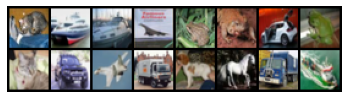

red   blue  blue  blue  green red   red   green
red   blue  blue  red   red   red   blue  green


In [7]:
# take a look at the dataset
dataiter = iter(test_dl)
images, labels = next(dataiter)
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()
imshow(torchvision.utils.make_grid(denormalize(images[0:16,:,:,:], cifar10_mean, cifar10_std)))
classes = ('red', 'green', 'blue', 'grayscale')
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8,16)))

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        
        # Conv Layer 1
        self.conv1 = nn.Conv2d(
            in_channels=in_channels, out_channels=out_channels,
            kernel_size=(3, 3), stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # Conv Layer 2
        self.conv2 = nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=(3, 3), stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)
    
        # Shortcut connection to downsample residual
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            # In case the output dimensions of the residual block is not the same 
            # as it's input, have a convolutional layer downsample the layer 
            # being bought forward by approporate striding and filters
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_channels=in_channels, out_channels=out_channels,
                    kernel_size=(1, 1), stride=stride, bias=False
                ),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = nn.ReLU()(out)
        return out


class ResNet(nn.Module):
    def __init__(self, num_classes=4):
        super(ResNet, self).__init__()
        
        # Initial input conv
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=64, kernel_size=(3, 3),
            stride=1, padding=1, bias=False
        )

        self.bn1 = nn.BatchNorm2d(64)
        
        # Create blocks
        self.block1 = self._create_block(64, 64, stride=1)
        self.block2 = self._create_block(64, 128, stride=2)
        self.block3 = self._create_block(128, 256, stride=2)
        self.block4 = self._create_block(256, 512, stride=2)
        self.linear = nn.Linear(512, num_classes)
    
    def _create_block(self, in_channels, out_channels, stride):
        return nn.Sequential(
            ResidualBlock(in_channels, out_channels, stride),
            ResidualBlock(out_channels, out_channels, 1)
        )

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = nn.AvgPool2d(4)(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [9]:
### define the training loop

def accuracy(logits, labels):
    _, pred_class_id = torch.max(logits, dim=1)
    return torch.tensor(torch.sum(pred_class_id == labels).item() / len(logits))

def evaluate(model, dl, loss_func):
    model.eval()
    batch_losses, batch_accs = [], []
    for data in dl:
        images, labels = data[0].to(device), data[1].to(device)
        with torch.no_grad():
            logits = model(images)
            batch_losses.append(loss_func(logits, labels))
            batch_accs.append(accuracy(logits, labels))
    epoch_avg_loss = torch.stack(batch_losses).mean().item()
    epoch_avg_acc = torch.stack(batch_accs).mean()
    return epoch_avg_loss, epoch_avg_acc

def train(model, train_dl, valid_dl, max_lr, epochs, loss_func, optim):
    optimizer = optim(model.parameters(), max_lr)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs * len(train_dl))

    results = {'avg_train_loss': [],
               'avg_valid_loss': [],
               'avg_valid_acc': []}
    mini_batch_preview = int(np.floor(len(train_dl) / 3 / 100) * 100) # 3 previews per epoch
    for epoch in range(epochs):
        model.train()
        train_losses = []
        running_loss = 0.0
        running_acc = []
        for i, data in enumerate(train_dl):
            images, labels = data[0].to(device), data[1].to(device)
            logits = model(images)
            
            loss = loss_func(logits, labels)
            train_losses.append(loss)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()

            running_loss += loss.item()
            running_acc.append(accuracy(logits, labels))
            if i % mini_batch_preview == mini_batch_preview-1:    # print mini_batch_preview 
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / mini_batch_preview:.3f}, acc: {torch.stack(running_acc).mean():.1%}')
                running_acc = []
                running_loss = 0.0
        epoch_train_loss = torch.stack(train_losses).mean().item()
        epoch_avg_loss, epoch_avg_acc = evaluate(model, valid_dl, loss_func)
        results['avg_train_loss'].append(epoch_train_loss)
        results['avg_valid_loss'].append(epoch_avg_loss)
        results['avg_valid_acc'].append(epoch_avg_acc)

        if epoch == 0:
            best_model = model
        elif results['avg_valid_loss'][epoch] < results['avg_valid_loss'][epoch-1]:
            best_model = model

    return results, best_model

In [10]:
model = ResNet().to(device)
epochs = 2
max_lr = 1e-2
optimizer = optim.Adam
loss_func = F.cross_entropy
results, trained_model = train(model=model, train_dl=train_dl, valid_dl=valid_dl, epochs=epochs,
                               max_lr=max_lr, optim=optimizer, loss_func=loss_func)

[1,   200] loss: 0.411, acc: 84.7%
[1,   400] loss: 0.392, acc: 85.5%
[1,   600] loss: 0.334, acc: 87.3%
[2,   200] loss: 0.274, acc: 89.3%
[2,   400] loss: 0.235, acc: 90.8%
[2,   600] loss: 0.205, acc: 91.7%


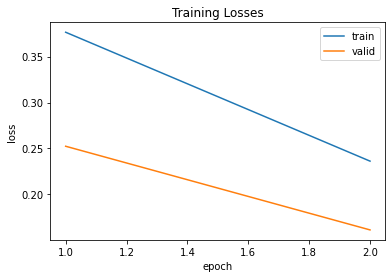

In [11]:
plt.plot(range(1, epochs+1), results['avg_train_loss'], label='train')
plt.plot(range(1, epochs+1), results['avg_valid_loss'], label='valid')
plt.title('Training Losses')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

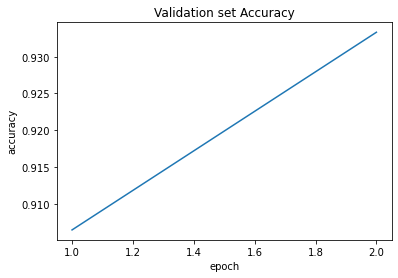

In [12]:
plt.plot(range(1, epochs+1), results['avg_valid_acc'], label='valid')
plt.title('Validation set Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

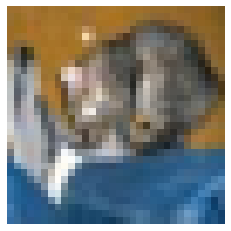

Predicted: red (98.6%) | GT: red


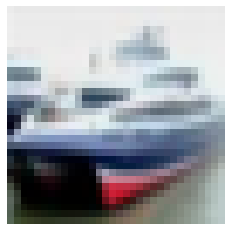

Predicted: blue (96.2%) | GT: blue


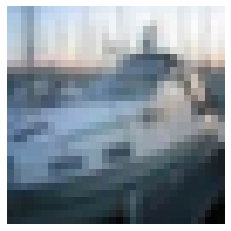

Predicted: blue (100.0%) | GT: blue


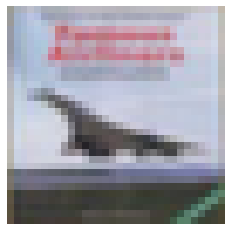

Predicted: blue (97.4%) | GT: blue


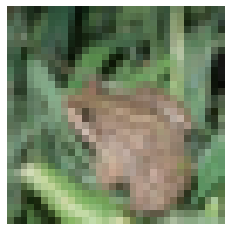

Predicted: green (99.8%) | GT: green


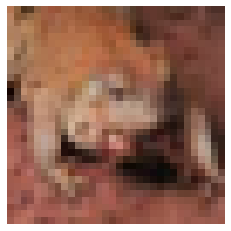

Predicted: red (100.0%) | GT: red


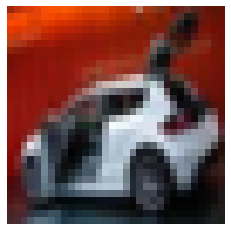

Predicted: red (99.0%) | GT: red


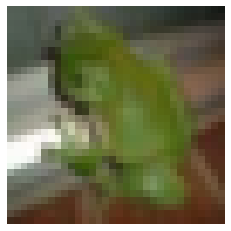

Predicted: green (64.1%) | GT: green


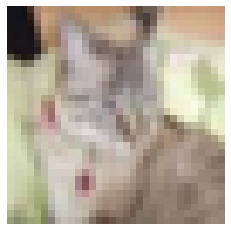

Predicted: red (100.0%) | GT: red


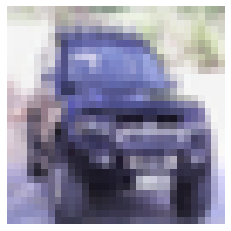

Predicted: blue (100.0%) | GT: blue


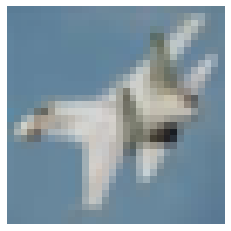

Predicted: blue (100.0%) | GT: blue


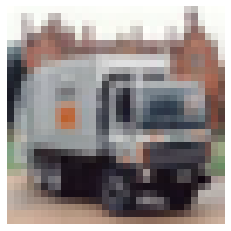

Predicted: red (99.6%) | GT: red


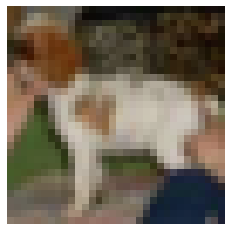

Predicted: red (100.0%) | GT: red


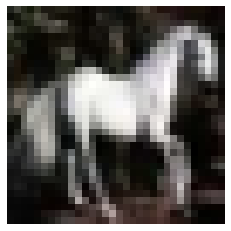

Predicted: red (97.9%) | GT: red


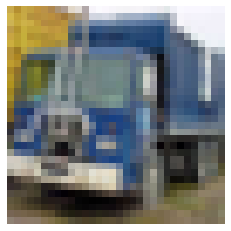

Predicted: blue (83.1%) | GT: blue


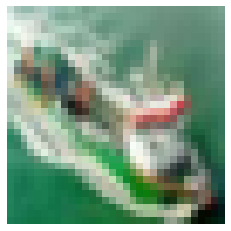

Predicted: green (99.9%) | GT: green


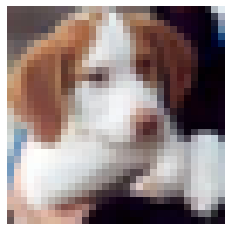

Predicted: red (99.9%) | GT: red


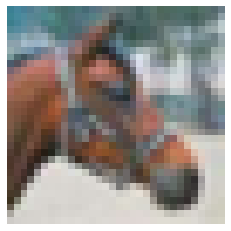

Predicted: red (98.6%) | GT: red


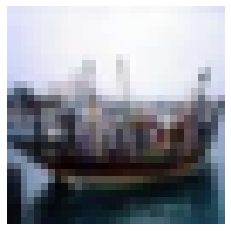

Predicted: blue (96.4%) | GT: blue


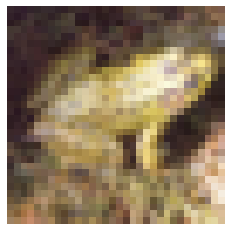

Predicted: red (100.0%) | GT: red


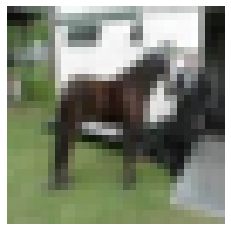

Predicted: green (97.3%) | GT: green


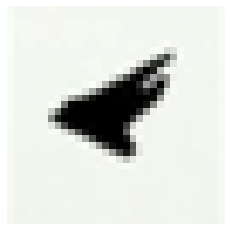

Predicted: grayscale (58.0%) | GT: green


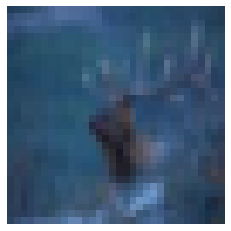

Predicted: blue (100.0%) | GT: blue


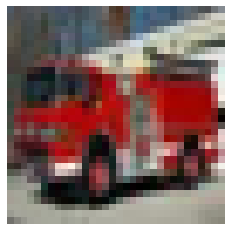

Predicted: red (100.0%) | GT: red


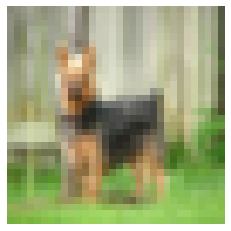

Predicted: green (89.9%) | GT: green


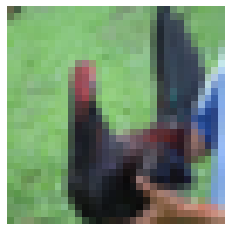

Predicted: green (99.1%) | GT: green


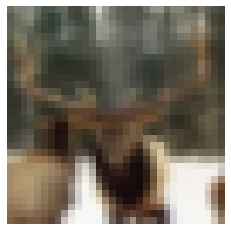

Predicted: red (100.0%) | GT: red


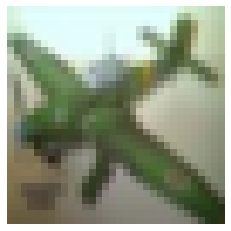

Predicted: green (93.0%) | GT: green


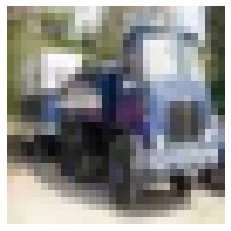

Predicted: red (56.1%) | GT: blue


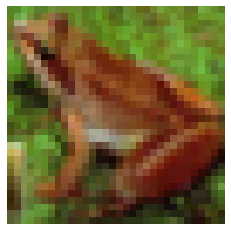

Predicted: red (97.0%) | GT: red


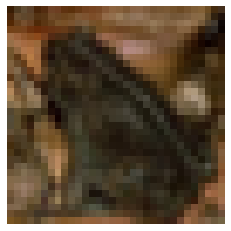

Predicted: red (100.0%) | GT: red


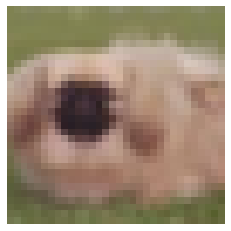

Predicted: red (100.0%) | GT: red


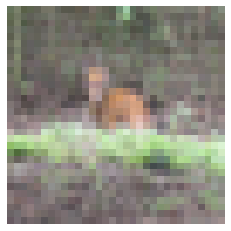

Predicted: red (94.7%) | GT: red


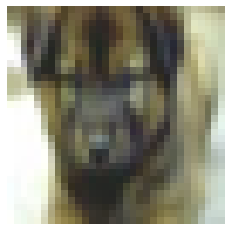

Predicted: red (99.9%) | GT: red


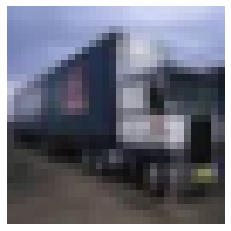

Predicted: blue (99.8%) | GT: blue


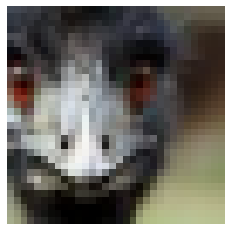

Predicted: red (99.4%) | GT: red


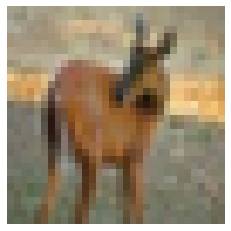

Predicted: red (100.0%) | GT: red


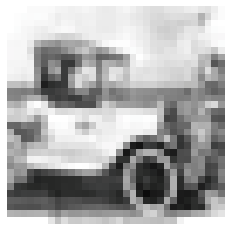

Predicted: grayscale (69.4%) | GT: grayscale


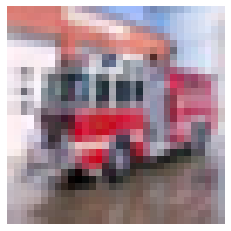

Predicted: red (99.9%) | GT: red


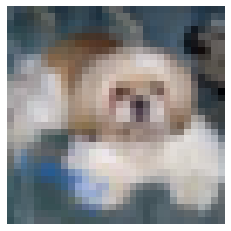

Predicted: red (55.0%) | GT: blue


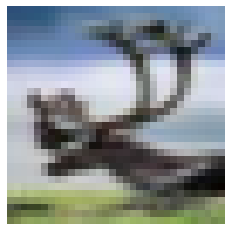

Predicted: blue (86.2%) | GT: blue


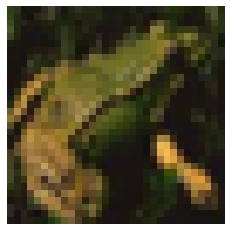

Predicted: red (100.0%) | GT: red


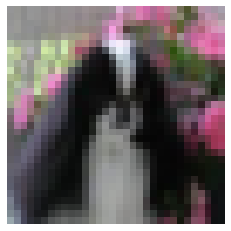

Predicted: red (98.8%) | GT: red


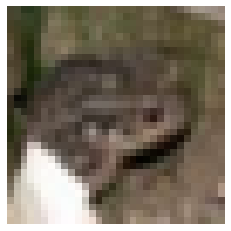

Predicted: red (100.0%) | GT: red


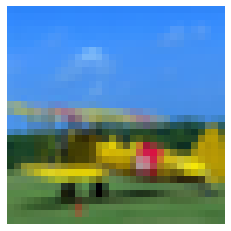

Predicted: blue (98.1%) | GT: blue


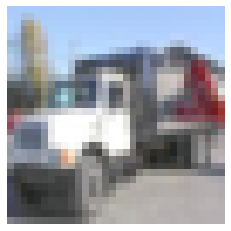

Predicted: blue (95.0%) | GT: blue


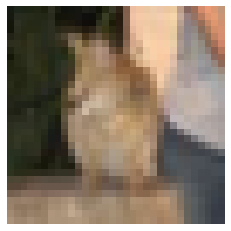

Predicted: red (100.0%) | GT: red


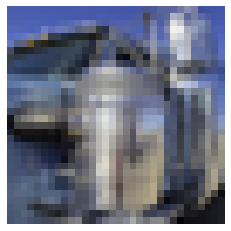

Predicted: blue (100.0%) | GT: blue


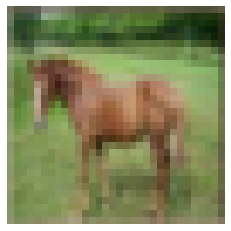

Predicted: green (99.3%) | GT: green


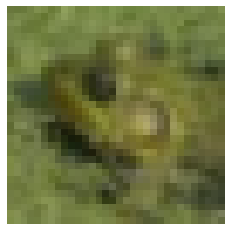

Predicted: green (99.9%) | GT: green


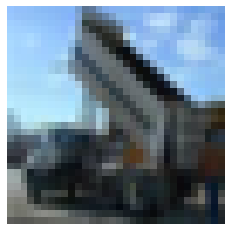

Predicted: blue (100.0%) | GT: blue


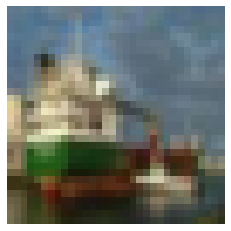

Predicted: blue (77.0%) | GT: blue


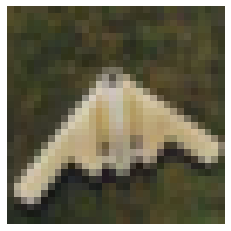

Predicted: red (99.9%) | GT: red


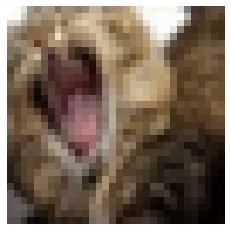

Predicted: red (100.0%) | GT: red


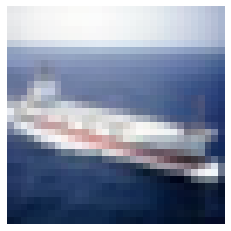

Predicted: blue (100.0%) | GT: blue


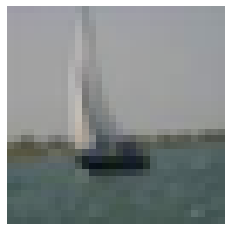

Predicted: green (56.7%) | GT: green


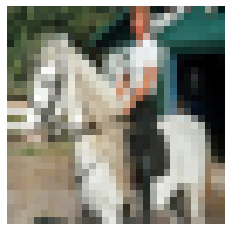

Predicted: red (95.9%) | GT: red


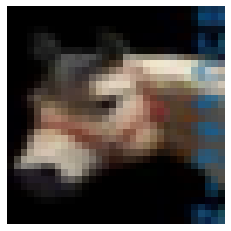

Predicted: red (98.0%) | GT: red


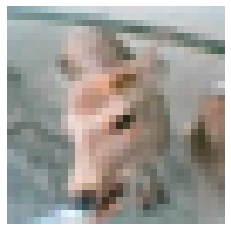

Predicted: red (98.6%) | GT: red


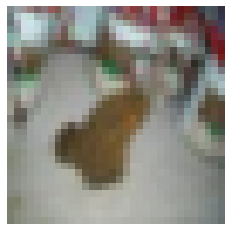

Predicted: red (99.2%) | GT: red


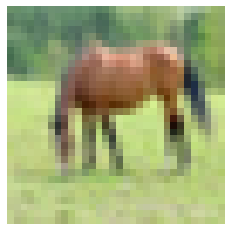

Predicted: green (99.8%) | GT: green


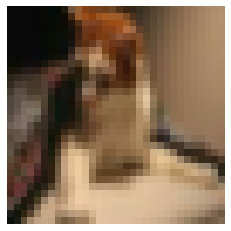

Predicted: red (100.0%) | GT: red


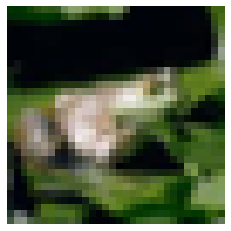

Predicted: green (99.0%) | GT: green


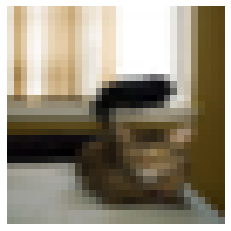

Predicted: red (100.0%) | GT: red


In [13]:
### Check results of one batch from the test dataset
dataiter = iter(test_dl)
images, labels = next(dataiter)
outputs = trained_model(images.to(device))
probabilities = F.softmax(outputs, dim=1)
confidence, pred_id = torch.max(probabilities.squeeze(), 1)
for j in range(batch_size):
    imshow(torchvision.utils.make_grid(denormalize(images[j,:,:,:], cifar10_mean, cifar10_std)))
    print(f'Predicted: {classes[pred_id[j]]} ({confidence[j]:.1%}) | GT: {classes[labels[j]]}')

In [14]:
### Accuracy of the whole test set
_, acc_test_ds = evaluate(trained_model, test_dl, loss_func)
print(f'Accuracy of the network on the {len(test_dl.dataset)} test images: {acc_test_ds:.1%} ')

Accuracy of the network on the 10000 test images: 93.7% 


In [15]:
### Accuracy for each class
# Count predictions for each class
classes = ('red', 'green', 'blue', 'grayscale')
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in test_dl:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = trained_model(images)
        _, pred_id = torch.max(outputs, 1)
        for label, prediction in zip(labels, pred_id):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:9s} is {accuracy:.1%} (total imgs = {total_pred[classname]})')

Accuracy for class: red       is 98.7% (total imgs = 5361)
Accuracy for class: green     is 83.7% (total imgs = 1837)
Accuracy for class: blue      is 90.2% (total imgs = 2682)
Accuracy for class: grayscale is 100.0% (total imgs = 120)


#### Conclusion

From the results above we can see the model was able to generalize well for the test dataset images.

**Bonus**
